In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
from inpainting.dataset import Data, ResizeTransform, ConditionSampler
from gan.conditional_gan import Generator5Net, Discriminator5
from gan.losses import GeneratorLoss, DiscriminatorLoss
from gan.trainer import GanTrainer
from torch.utils.data import DataLoader 
from torch.utils.data.dataset import Subset
import torch
import matplotlib.pyplot as plt
import pandas as pd
from inpainting.visualize import plot_batch
from inpainting.visualize import cGanPlotLossCallback, ConditionDescriber
from inpainting import cond_celeba_config as conf
from inpainting.visualizer import Visualizer

%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


In [2]:
torch.cuda.set_device(conf.CUDA_DEVICE)

In [3]:

transform = ResizeTransform()
data = Data(conf.DATA_PATH, transform, return_attr=True, conditions=conf.conditions)
noise_sampler = ConditionSampler(data, conf.Z_SIZE)
#data = Subset(data, range(100))
data_loader = DataLoader(data, batch_size=conf.BATCH_SIZE, num_workers=conf.NUM_WORKERS, shuffle=True)
print('Dataset size: ', len(data))
print('y size: ', conf.Y_SIZE)


Dataset size:  202599
y size:  5


tensor([-1.,  1., -1.,  1., -1.], device='cuda:1')


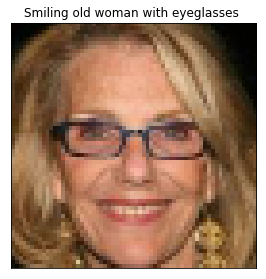

In [9]:
cd = ConditionDescriber(conf.conditions)
y = cd.create_y(Male=False, Smiling=True, Young=False, Eyeglasses=True)
#y = np.array([0, 1, 0, 0, 0])*2 - 1
idx = data.find_image(y)
img, y_new = data[idx]
print(y_new)
img = img.cpu().numpy()
plot_batch([img], normalize=True, limit=1, descriptions=[cd.describe(y)])

In [10]:
generator = Generator5Net(conf.Z_SIZE, conf.Y_SIZE).cuda()
discriminator = Discriminator5(conf.Y_SIZE).cuda()

In [11]:
visualizer = Visualizer(conf, noise_sampler)
trainer = GanTrainer(generator, discriminator, conf, noise_sampler, visualizer=visualizer)

In [12]:
if conf.CONTINUE_TRAINING:
    trainer.load_last_checkpoint()
    
trainer.train(data_loader, n_epochs=280)

Update losses
show_generator_results
Update losses
show_generator_results


KeyboardInterrupt: 

In [13]:
LOAD_MODEL = True
LOAD_EPOCH_N = 2
if LOAD_MODEL:
    generator.load_state_dict(torch.load(conf.MODEL_PATH + 'generator_%d.pth' % (LOAD_EPOCH_N,)))
    discriminator.load_state_dict(torch.load(conf.MODEL_PATH + 'discriminator_%d.pth' % (LOAD_EPOCH_N,)))
    generator.eval()
    discriminator.eval()

Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


In [14]:

visualizer.update_losses(2., 7., type='validation')
visualizer.update_losses(4., 8., type='validation')
visualizer.update_losses(6., 9., type='validation')

Update losses
Update losses
Update losses


<class 'numpy.dtype'>
D_real:  0.2239057421684265 D_fake:  0.4844355881214142
D_logit_real:  -1.2430487871170044 D_logit_fake:  -0.06227774918079376
Discriminator loss:  1.0018210411071777
0.9562692642211914


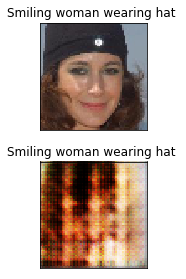

In [18]:
scalar = lambda v: np.asscalar(v.data.cpu().numpy())

Z = torch.normal(mean=torch.zeros(1, generator.z_size)).cuda()
        # 'Male', 'Smiling', 'Young', 'Eyeglasses', 'Wearing_Hat'
y = cd.create_y(Male=False, Smiling=True, Young=True, Eyeglasses=False, Wearing_Hat=True)
print(dtype)
idx = data.find_image(y)
img, y_new = data[idx]
X = img.unsqueeze(0)
y = y.astype(np.float32)
Y = torch.tensor([y]).cuda()

G_sample = generator(Z, Y)
D_real, D_logit_real = discriminator(X, Y)
D_fake, D_logit_fake = discriminator(G_sample, Y)

generator_loss = GeneratorLoss()
discriminator_loss = DiscriminatorLoss(label_smoothing=0.25)

print("D_real: ", scalar(D_real), "D_fake: ", scalar(D_fake))
print("D_logit_real: ", scalar(D_logit_real), "D_logit_fake: ", scalar(D_logit_fake))

d_loss = discriminator_loss(D_logit_real, D_logit_fake)

print("Discriminator loss: ", scalar(d_loss))
print(scalar(discriminator_loss(torch.tensor([10.0]).cuda(), D_logit_fake)))
sample = np.concatenate((img[None, :, :, :], G_sample.data.cpu().numpy()))
plot_batch(sample, normalize=True, descriptions=[cd.describe(y)]*2)

In [20]:
w = discriminator.layer4[0].weight.data.cpu().numpy()
print(w.shape)
print(w[:, 0:5])
print(w[:, 5:])

(512, 2048)
[[ 0.01980729 -0.01842786 -0.00261583 -0.00568159  0.01574252]
 [ 0.02154603  0.00216528  0.00160701  0.00391417 -0.01336127]
 [-0.01008663  0.02214671 -0.01278567  0.00233722  0.02314615]
 ...
 [ 0.01581815  0.00711341  0.01547275 -0.01360126  0.01397711]
 [ 0.01619699 -0.01206617 -0.00214138 -0.01691107 -0.01783075]
 [ 0.01328041 -0.00390453  0.00298822  0.02940079  0.00404614]]
[[ 0.01780465 -0.0199886  -0.00901466 ... -0.01180498 -0.00577727
  -0.00538913]
 [ 0.00939254  0.007148   -0.0193029  ...  0.01834289  0.00112092
  -0.0122321 ]
 [ 0.00345433 -0.01363221 -0.01510157 ... -0.00503463  0.00356854
   0.01995964]
 ...
 [ 0.01472225 -0.01457678 -0.00153125 ... -0.01819693  0.02348176
  -0.00893753]
 [ 0.00183028  0.02622049 -0.00463922 ...  0.02304176  0.01169394
   0.01228152]
 [ 0.01052865 -0.00385452 -0.01486127 ... -0.0143024   0.00389751
  -0.00620906]]
